In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, Flatten, MaxPooling1D, Activation, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 一、載入資料

1.1. 載入資料

In [2]:
data = pd.read_csv('/Users/yitsung/Desktop/MasterThesis/data/TaiwanStockData_Top100_EMA')
ticker_2330 = data[data['ticker']==2330].reset_index(drop=True)
ticker_2330 = ticker_2330.drop(columns=['ticker'])
ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.2.轉換成EMA+return data

In [3]:
# origi_data #
origi_data = ticker_2330.copy() # 用來之後還原答案的

# ticker_2330['open'] = ticker_2330['open'].diff()
# ticker_2330['high'] = ticker_2330['high'].diff()
# ticker_2330['low'] = ticker_2330['low'].diff()
# ticker_2330['close'] = ticker_2330['close'].diff()

# # EMA diff #
# ticker_2330['EMA9'] = ticker_2330['EMA9'].diff()
# ticker_2330['EMA12'] = ticker_2330['EMA12'].diff()
# ticker_2330['EMA26'] = ticker_2330['EMA26'].diff()

# ticker_2330.replace([float('inf'), -float('inf')], 0, inplace=True) # 不知道為何有些調整過後會變inf, 要拿掉(應該是連兩天的價格都相同)
# ticker_2330 = ticker_2330.dropna().reset_index(drop=True)

ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.3.切Library和Prediction

In [4]:
Library = ticker_2330[ticker_2330['Date'] <= '2023-06-30'] # windows=20, 最後預測到6/30
Prediction = ticker_2330[(ticker_2330['Date'] >= '2023-06-01')&(ticker_2330['Date'] <= '2023-10-31')] # windows=20, 從6/1預測7/3開始
Prediction.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
681,2023-10-25,544.0,551.0,544.0,544.0,17137.0,-99.0,-2573.0,651.0,-142.0,1185.0,3.9095,544.649068,543.673118,541.716547,1.956572,0.734048,91.909547
682,2023-10-26,530.0,535.0,530.0,531.0,31683.0,487.0,-10712.0,-35173.0,-1744.0,-10261.0,6.9033,541.919255,541.723408,540.922728,0.800679,0.747374,85.178131
683,2023-10-27,534.0,536.0,532.0,533.0,17051.0,17.0,-5262.0,1478.0,-73.0,-1739.0,4.1968,540.135404,540.381345,540.335860,0.045485,0.606996,78.927028
684,2023-10-30,531.0,534.0,528.0,532.0,23299.0,265.0,-11811.0,487.0,378.0,-5803.0,5.6532,538.508323,539.091907,539.718389,-0.626481,0.360301,72.836426
685,2023-10-31,535.0,535.0,527.0,529.0,28073.0,113.0,-9363.0,495.0,-358.0,-5392.0,5.4314,536.606658,537.539306,538.924434,-1.385128,0.011215,63.359478


### 二、資料分拆

2.1.MinMax

In [5]:
def make_data_minmax(Library, Prediction, target):

    # 將target放至最後面 #
    Library_target_col = Library.pop(f'{target}')
    Library[f'{target}'] = Library_target_col
    Prediction_target_col = Prediction.pop(f'{target}')
    Prediction[f'{target}'] = Prediction_target_col

    # MinMax #
    scaler_X = MinMaxScaler()
    feature_to_standardize = Library.columns.to_list()[1 : -1]
    Library[feature_to_standardize] = scaler_X.fit_transform(Library[feature_to_standardize])
    Prediction[feature_to_standardize] = scaler_X.fit_transform(Prediction[feature_to_standardize])

    scaler_y = MinMaxScaler()
    Lib_ans = Library.iloc[:, -1].values.reshape(-1, 1)
    Library.iloc[:, -1] = scaler_y.fit_transform(Lib_ans)
    Pred_ans = Prediction.iloc[:, -1].values.reshape(-1, 1)
    Prediction.iloc[:, -1] = scaler_y.fit_transform(Pred_ans)

    return Library, Prediction, scaler_y

In [6]:
### 切train和validation ###
train_Library = Library[: int((len(Library) * 0.8))]
valid_Library = Library[int((len(Library) * 0.8)): ]
train_Library, valid_Library, scaler_y = make_data_minmax(Library=train_Library, Prediction=valid_Library, target='close')

### 切完整data ###
Library, Prediction, scaler_y = make_data_minmax(Library=Library, Prediction=Prediction, target='close')

2.2.製作data

In [7]:
def create_dataset(data, windows, Tp, target):

    data = data.drop(columns=['Date'])
    num_of_target_col = data.columns.to_list().index(f'{target}')

    X, y = [], []
    for i in range(len(data) - windows - (Tp - 1)): # 預測t+1:-0, 預測t+2:-1 ...
        X.append(data.iloc[i:(i + windows)])
        y.append(data.iloc[i + windows + (Tp - 1), num_of_target_col])  # 預測t+1:+0, 預測t+2:+1 ... # 後面那個是target的索引

    X, y = np.array(X), np.array(y)
        
    return X, y

In [8]:
train_X, train_y = create_dataset(data=train_Library, windows=20, Tp=1, target='close')
valid_X, valid_y = create_dataset(data=valid_Library, windows=20, Tp=1, target='close')
X, y = create_dataset(data=Library, windows=20, Tp=1, target='close')
pred_X, pred_y = create_dataset(data=Prediction, windows=20, Tp=1, target='close')

2.2.5. Flatten (MLP only)

In [9]:
def make_X_flatten(X):
    X_flatten = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

    return X_flatten

In [10]:
# train_X = make_X_flatten(train_X)
# valid_X = make_X_flatten(valid_X)
# pred_X = make_X_flatten(pred_X)

### 三、建模分析

3.1. 建構CNN-LSTM model

In [11]:
def create_cnn_lstm(hp, num_columns):

    ################## Parameters ######################
    units_1 = hp.Int(name="units_1", min_value=16, max_value=128, step=16)
    units_2 = hp.Int(name="units_2", min_value=16, max_value=128, step=16)
    units_3 = hp.Int(name="units_3", min_value=16, max_value=128, step=16)
    units_4 = hp.Int(name="units_4", min_value=16, max_value=128, step=16)

    dropout_1 = hp.Choice("dropout_1", [0.0, 0.2, 0.5, 0.8])
    dropout_2 = hp.Choice("dropout_2", [0.0, 0.2, 0.5, 0.8])
    dropout_3 = hp.Choice("dropout_3", [0.0, 0.2, 0.5, 0.8])

    lr = hp.Choice('lr',[1e-2, 1e-3, 1e-5])
    ####################################################

    inp = Input(shape = (num_columns[1], num_columns[2]))

    cnn = Conv1D(units_1, 5, padding='same', strides=1, activation='relu')(inp)
    cnn = MaxPooling1D(2)(cnn)
    cnn = Dropout(dropout_1)(cnn)

    x = Reshape((20, -1))(cnn) # 第一個數字要填windows的數字

    lstm = LSTM(units_2, return_sequences=True)(x)
    lstm = LSTM(units_3)(lstm)
    lstm = Dropout(dropout_2)(lstm)

    x = Dense(units_4)(lstm)
    x = Activation('relu')(x)
    x = Dropout(dropout_3)(x)

    out = Dense(1)(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
                  loss='mean_squared_error',
                  metrics='mean_squared_error')

    
    return model

In [12]:
TUNNING = True

if TUNNING:
    model_fn = lambda hp: create_cnn_lstm(hp, num_columns=train_X.shape)
    tuner = kt.BayesianOptimization(model_fn,
                                    objective='val_mean_squared_error',
                                    max_trials=1,
                                    executions_per_trial=1,
                                    directory="CNN_LSTM_price_kt",
                                    overwrite=True,
                                    seed=87)
    
    es = EarlyStopping(monitor='val_mean_squared_error', min_delta=1e-4, patience=10,
                       baseline=None, restore_best_weights=True, verbose=0)
    
    tuner.search(train_X, train_y, validation_data=(valid_X, valid_y), epochs=100, 
                 batch_size=16, callbacks=[es], verbose=1)
    
    CNN_LSTM_model = tuner.get_best_models()[0]

Trial 1 Complete [00h 00m 17s]
val_mean_squared_error: 0.017155565321445465

Best val_mean_squared_error So Far: 0.017155565321445465
Total elapsed time: 00h 00m 17s


In [13]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Best Hyperparameters:
{'units_1': 32, 'units_2': 64, 'units_3': 16, 'units_4': 32, 'dropout_1': 0.0, 'dropout_2': 0.2, 'dropout_3': 0.8, 'lr': 0.001}


3.3.完整訓練cnn-lstm

In [14]:
def create_cnn_lstm(num_columns, hidden_units, dropout_rates, lr):

    inp = Input(shape = (num_columns[1], num_columns[2]))

    cnn = Conv1D(hidden_units[0], 5, padding='same', strides=1, activation='relu')(inp)
    cnn = MaxPooling1D(2)(cnn)
    cnn = Dropout(dropout_rates[0])(cnn)

    x = Reshape((20, -1))(cnn) # 第一個數字要填window數

    lstm = LSTM(hidden_units[1], return_sequences=True)(x)
    lstm = LSTM(hidden_units[2])(lstm)
    lstm = Dropout(dropout_rates[1])(lstm)

    x = Dense(hidden_units[3])(lstm)
    x = Activation('relu')(x)
    x = Dropout(dropout_rates[2])(x)

    out = Dense(1)(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
                  loss='mean_squared_error',
                  metrics='mean_squared_error')

    
    return model

params = {'num_columns': train_X.shape,
          'hidden_units': [64, 128, 32, 64],
          'dropout_rates': [0.0, 0.2, 0.8],
          'lr': 0.001}

In [15]:
def train_CNN_LSTM(batch_size, X, y):

    CNN_LSTM_path = f'CNN_LSTM.hdf5'

    model = create_cnn_lstm(**params)
    ckp = ModelCheckpoint(CNN_LSTM_path, monitor='val_mean_squared_error', verbose=0, 
                        save_best_only=True, save_weights_only=True)
    es = EarlyStopping(monitor='val_mean_squared_error', min_delta=1e-4, patience=10, 
                       baseline=None, restore_best_weights=True, verbose=0)
    history = model.fit(X, y, validation_data=(valid_X, valid_y),
                        # sample_weight = sw[tr], 
                        epochs=100, batch_size=batch_size, callbacks=[ckp, es], verbose=1)

    hist = pd.DataFrame(history.history)
    score = hist['val_mean_squared_error'].min()
    print(f'MSE:', score)

    return history, model

history, model = train_CNN_LSTM(batch_size=16, X=train_X, y=train_y)

Epoch 1/100
29/29 [==============================] - 2s 38ms/step - loss: 0.0755 - mean_squared_error: 0.0755 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 2/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 3/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 4/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 7/100
29/29 [=========

3/3 [==============================] - 0s 25ms/step


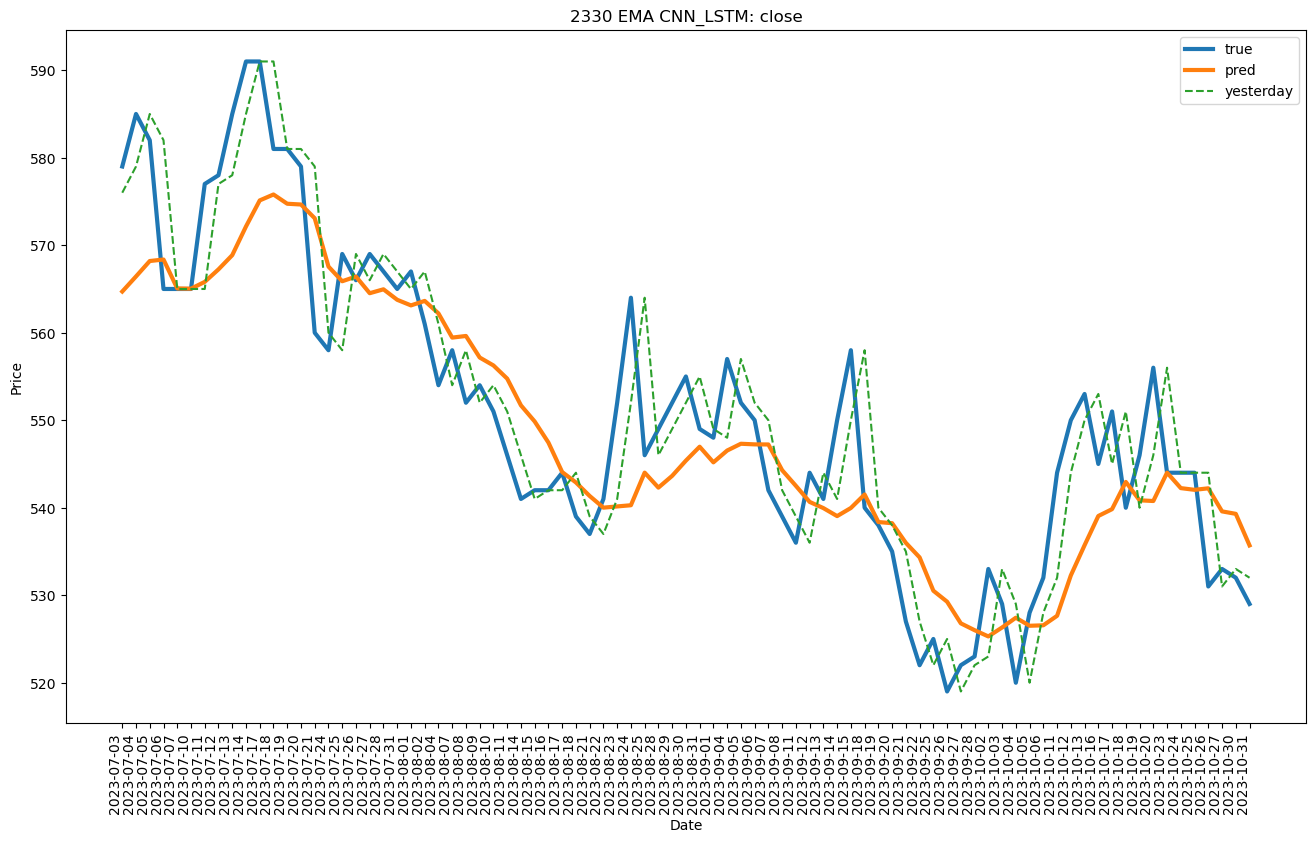

,Date,Observations,Predictions,Yesterday
0,2023-07-03,579.0,564.708252,576.0
1,2023-07-04,585.0,566.432129,579.0
2,2023-07-05,582.0,568.193420,585.0
3,2023-07-06,565.0,568.366760,582.0
4,2023-07-07,565.0,565.059692,565.0
...,...,...,...,...
78,2023-10-25,544.0,542.045349,544.0
79,2023-10-26,531.0,542.217651,544.0
80,2023-10-27,533.0,539.582031,531.0
81,2023-10-30,532.0,539.299561,533.0


In [16]:
def test_model(pred_X, model):

    ### 預測 ###
    y_pred = model.predict(pred_X)
    y_pred = y_pred.reshape(-1,1) # reshape成可以還原的格式
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = pd.Series(y_pred.reshape(-1)) # 變成series格式化成相同index方便畫圖

    # 取得前一日資料
    yesterday = origi_data[(origi_data['Date']>='2023-06-30') & (origi_data['Date']<'2023-10-31')].reset_index(drop=True)
    # 取得今日資料
    Today = origi_data[(origi_data['Date']>='2023-07-01') & (origi_data['Date']<'2023-11-01')].reset_index(drop=True)
    # Date
    Date = origi_data[(origi_data['Date']>='2023-07-01') & (origi_data['Date']<'2023-11-01')].reset_index()

    # 製作還原預測資料
    CNN_LSTM_result = pd.DataFrame(yesterday['close'])
    CNN_LSTM_result = CNN_LSTM_result.rename(columns={'close': 'Yesterday'})

    CNN_LSTM_result['Predictions'] = y_pred # origin
    # CNN_LSTM_result['Predictions'] = CNN_LSTM_result['Yesterday'] + y_pred # diff

    CNN_LSTM_result['Observations'] = Today['close']   
    CNN_LSTM_result['Date'] = Date['Date']

    CNN_LSTM = CNN_LSTM_result[['Date', 'Observations', 'Predictions', 'Yesterday']]

    # 繪圖
    plt.figure(figsize=(16, 9))
    plt.plot(CNN_LSTM['Date'], CNN_LSTM[f'Observations'], linewidth=3, label='true')
    plt.plot(CNN_LSTM['Date'], CNN_LSTM[f'Predictions'], linewidth=3, label='pred')
    plt.plot(CNN_LSTM['Date'], CNN_LSTM[f'Yesterday'], linestyle='--', label='yesterday')

    plt.xlabel('Date')
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Price')
    plt.title(f'2330 EMA CNN_LSTM: close')
    plt.legend()
    plt.show()

    return CNN_LSTM

CNN_LSTM = test_model(pred_X=pred_X, model=model)
CNN_LSTM